In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import skimage
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(42)

In [15]:
dataset_path = './asl_dataset'
class_names = [
  '0','1','2','3','4','5','6',
  '7','8','9','a','b','c','d',
  'e','f','g','h','i','j','k',
  'l','m','n','o','p','q','r',
  's','t','u','v','w','x','y',
  'z'
]
# Loading and preprocessing Image Data https://www.section.io/engineering-education/image-preprocessing-in-python/#:~:text=In%20this%20tutorial%2C%20we%20shall,used%20to%20preprocess%20image%20data.
dataPaths = []
for i in range(len(class_names)):
  path = os.path.join(dataset_path, class_names[i], '*')
  path = glob.glob(path)
  dataPaths.append(path)


# Merging Dataframes: https://www.stackvidhya.com/add-row-to-dataframe/
df = pd.DataFrame()
for i in range(len(dataPaths)):
  current_df = pd.DataFrame({"path": dataPaths[i], "category": class_names[i]})
  df = pd.concat([df, current_df], ignore_index=True, axis=0)
df.to_csv(f'./temp/categorized.csv')


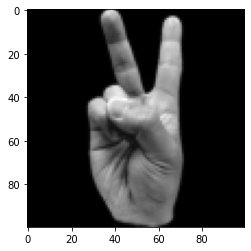

In [16]:
# gray_image = skimage.color.rgb2gray(io.imread(df['path'][200]))
# Starting with downscaled image
gray_image = rescale(skimage.color.rgb2gray(io.imread(df['path'][200])), 0.25)
plt.imshow(gray_image, cmap = 'gray')
pixels = gray_image.shape[0] * gray_image.shape[1]



In [17]:
column_names = []
[column_names.append("p"+str(x)) for x in range(0,pixels)] # shape (785,0)
column_names.append("category")
numberized_df = pd.DataFrame(columns=column_names)
for i in range(len(class_names)):
  print(class_names[i])
  for j in range(len(dataPaths[i])):
    image = io.imread(dataPaths[i][j])
    gray_image = rescale(skimage.color.rgb2gray(image), 0.25)
    numberized_image = gray_image.flatten()
    numberized_image = np.append(numberized_image, i)
    numberized_image_df = pd.DataFrame(columns=column_names)
    numberized_image_df.loc[0] = numberized_image
    numberized_df = pd.concat([numberized_df,numberized_image_df], ignore_index=True)

0
1
2
3
4
5
6
7
8
9
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z


In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(numberized_df, numberized_df['category']):
    train_set = numberized_df.loc[train_index]
    test_set = numberized_df.loc[test_index]

train_data = train_set.drop("category", axis=1) 
train_labels = train_set["category"].copy().to_numpy().astype('int')
print(train_labels)

test_data = test_set.drop("category", axis=1) 
test_labels = test_set["category"].copy().to_numpy().astype('int')
print(test_data.shape)

[14 24 20 ... 30 22 35]
(755, 10000)


In [19]:
# I THINK IT IS ALSREADY SCALED BETWEEN ! AND ) BUT JUST TO BE SAFE !!

# REVISIT LATER

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data.values)

scaled_df = pd.DataFrame(train_scaled, index=train_set.index, columns=train_data.columns)

print(np.max(scaled_df.p1.to_numpy()))
print(np.min(scaled_df.p1.to_numpy()))

1.0
0.0


In [29]:
model = SVC(random_state=42, probability=True)

# specify the parameter combinations to be tested
parameters = [
    {'C': [10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']}
]
grid_search = GridSearchCV(model, parameters)#, cv=10, return_train_score=True, n_jobs=-1)
grid_search.fit(train_scaled, train_labels)



GridSearchCV(estimator=SVC(probability=True, random_state=42),
             param_grid=[{'C': [10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'rbf']}])

In [21]:
train_predictions = grid_search.best_estimator_.predict(train_scaled)
cls_report_train = classification_report(train_labels, train_predictions)
print(cls_report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       1.00      1.00      1.00        49
          10       1.00      1.00      1.00        49
          11       1.00      1.00      1.00        49
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        49
          14       1.00      1.00      1.00        49
          15       1.00      1.00      1.00        49
          16       1.00      1.00      1.00        49
          17       1.00    

In [22]:
test_scaled = scaler.transform(test_data.values)
test_predictions = grid_search.best_estimator_.predict(test_scaled)
cls_report_test = classification_report(test_labels, test_predictions)
print(cls_report_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.90      0.95        21
           2       1.00      0.95      0.98        21
           3       1.00      1.00      1.00        21
           4       1.00      0.95      0.98        21
           5       1.00      1.00      1.00        21
           6       0.82      0.86      0.84        21
           7       1.00      0.90      0.95        21
           8       0.95      1.00      0.98        21
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        21
          14       1.00      1.00      1.00        21
          15       1.00      1.00      1.00        21
          16       1.00      1.00      1.00        21
          17       1.00    

In [ ]:
# Pipeline




# User Testing
After training the model, I decided to use an actual picture of my own to see if I can get the right output

C:\Users\amani\AppData\Local\Temp/ipykernel_14560/3447172321.py:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gray_image = resize(skimage.color.rgb2gray(io.imread(test)), (100, 100))


10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

10000


C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\amani\miniconda3\envs\csi4106\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature nam

predicted: a:0.11889700025186402 actual: a


predicted: f:0.11061119385947371 actual: b


predicted: p:0.10027571221507965 actual: c


predicted: r:0.2082548108620402 actual: d


predicted: z:0.09589362438968135 actual: e


predicted: 5:0.08941271000881906 actual: f


predicted: h:0.17496282316556805 actual: g


predicted: h:0.4351032199564626 actual: h


predicted: z:0.1480477156080823 actual: i


predicted: p:0.09753534902972621 actual: j


predicted: r:0.18927605668956488 actual: k


predicted: d:0.19307454147189926 actual: l


predicted: c:0.19016943957507962 actual: m


predicted: v:0.2310535286815476 actual: n


predicted: c:0.10340216502179927 actual: o


predicted: p:0.23240691646422956 actual: p


predicted: q:0.16279085525110568 actual: q


predicted: 5:0.10734708963708214 actual: r


predicted: 6:0.11733486215646177 actual: s


predicted: 6:0.14785590241435925 actual: t


predicted: z:0.15032088615092096 actual: u


predicted: 6:0.10840840485528315 actual: v


predicted: 6:0

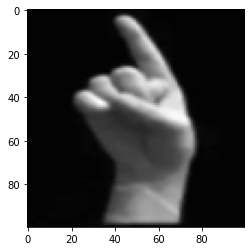

In [27]:
alpha = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
rezArray = []
for j in range(len(alpha)):
  test = "./"+alpha[j]+".PNG"
  gray_image = resize(skimage.color.rgb2gray(io.imread(test)), (100, 100))
  numberized_image = gray_image.flatten()
  print(len(numberized_image))
  column_names = []
  [column_names.append("p"+str(x)) for x in range(0,len(numberized_image))] # shape (785,0)
  numberized_df = pd.DataFrame(columns=column_names)

  numberized_df = pd.DataFrame(columns=column_names)
  numberized_image_df = pd.DataFrame(columns=column_names)
  numberized_image_df.loc[0] = numberized_image

  plt.imshow(gray_image, cmap = 'gray')
  rez = ""
  temp = 0
  for i in range(len(class_names)):
    if(temp < grid_search.predict_proba(numberized_image_df)[0][i]):
      rez = class_names[i]
      temp =  grid_search.predict_proba(numberized_image_df)[0][i]

  output = "predicted: "+ str(rez)+ ':'+ str(temp) + " actual: "+ str(alpha[j])
  rezArray.append(output)
for i in range(len(rezArray)):
  print(rezArray[i])
  print("\n")